In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import and Preprocess Data
We have three different datasets, (i) full dataset, (ii) subset of the full dataset, (iii) subset of the subset. Let us first import the datasets and plot them.

In [2]:
Full = pd.read_csv(os.path.join(os.path.dirname('__file__'), 'data', 'Full data.csv'))
Subset = pd.read_csv(os.path.join(os.path.dirname('__file__'), 'data', 'Subset data.csv'))
Subsubset = pd.read_csv(os.path.join(os.path.dirname('__file__'), 'data', 'Subsubset data.csv'))

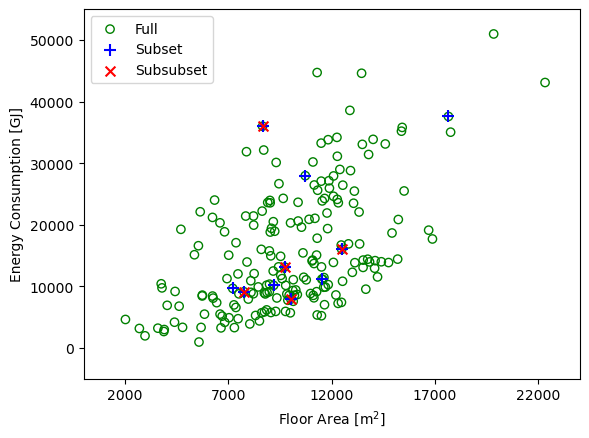

In [3]:
# plot
plt.subplots()
plt.scatter(Full['Area [m^2]'], Full['Energy [GJ]'], facecolors="None", edgecolors='g',label='Full')
plt.scatter(Subset['Area [m^2]'], Subset['Energy [GJ]'], color='b', marker='+',s=70,label='Subset')
plt.scatter(Subsubset['Area [m^2]'], Subsubset['Energy [GJ]'], color='r', marker='x',s=50,label='Subsubset')
plt.xlim(0,24000)
plt.xticks(np.arange(2000,23000,5000))
plt.xlabel('Floor Area [m$^2$]')
plt.ylim(-5000,55000)
plt.ylabel('Energy Consumption [GJ]')
plt.legend()
plt.show()

Let us preprocess the full dataset before training a model. We use a preprocessing tool, StandardScaler, in ***scikit learn*** package. Please refer to this [[**Link**]](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for more details. <br>

In [4]:
from sklearn import preprocessing

In [5]:
# Full
x_full = Full['Area [m^2]'].values[:,None]
y_full = Full['Energy [GJ]'].values[:,None]
Scale_x_full = preprocessing.StandardScaler() # StandardScaler for x_full
x_full_scaled = Scale_x_full.fit_transform(x_full) # fit the StandardScaler and transform x_full
Scale_y_full = preprocessing.StandardScaler() # StandardScaler for y_full
y_full_scaled = Scale_y_full.fit_transform(y_full) # fit the StandardScaler and transform y_full

# points to visualize the models
x_plot = np.linspace(2000, 22000,100)[:,None]
x_plot_full_scaled = Scale_x_full.transform(x_plot)

### Train a Model using the Full Dataset
First, we train a linear model with the full dataset. In this example, the **likelihood** function is:
$$
\begin{aligned}
& p(\mathbf{y}|\mathbf{x},\boldsymbol{\uptheta}):=\prod_{i=1}^{N}p(y^{(i)}|x^{(i)},\boldsymbol{\uptheta}) \\\\
& p(y^{(i)}|x^{(i)},\boldsymbol{\uptheta}):=\mathcal{N}(y^{(i)}|\hat{y}^{(i)},\sigma^2) \\\\
& \hat{y}=f(x;\boldsymbol{\uptheta})=\beta_1 \times x + \beta_0
\end{aligned}
$$ 
There are three random variables, $\boldsymbol{\uptheta}=(\beta_0,\beta_1,\sigma)$. Our goal in this modelling problem is to estimate the **posterior** probability distribution over these three random variables:
$$
p(\boldsymbol{\uptheta}|\mathbf{x},\mathbf{y}) \propto p(\mathbf{y}|\mathbf{x},\boldsymbol{\uptheta}) p(\boldsymbol{\uptheta})
$$
To this end, we need to determine the **prior** probability distribution, $p(\boldsymbol{\uptheta})$. In this example, we use
$$
\begin{aligned}
& p(\boldsymbol{\uptheta}) := p(\beta_0) p(\beta_1) p(\sigma) \\\\
& p(\beta_0) := \mathcal{N}(\beta_0|0,100) \\\\
& p(\beta_1) := \mathcal{N}(\beta_1|0,100) \\\\
& p(\sigma) := \text{Exp}(\sigma|1/100)
\end{aligned}
$$

We use the [[**PyMC package**]](https://www.pymc.io/welcome.html) for Bayesian modelling.

In [6]:
# import packages for Bayesian modelling
import pymc as pm
import arviz as az

The cell below shows how to construct the model with PyMC. You will find that the lines within **model_full** are aligned with the likelihood and prior above. <br>
By running the cell below, we get 3000 samples from [[**Markov chain Monte Carlo (MCMC)**]](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) chains. The distribution of the samples approximates the posterior distribution $p(\boldsymbol{\uptheta}|\mathbf{x},\mathbf{y})$.

In [7]:
# construct the model for the full dataset
model_full = pm.Model()
with model_full:
    # Prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.Exponential("sigma", lam=1/100)

    # Likelihood
    y_hat = beta[1] * x_full_scaled + beta[0]
    obs = pm.Normal("obs", mu=y_hat, sigma=sigma, observed=y_full_scaled)

    # draw 1000 posterior samples
    samples_full = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 43 seconds.


The figures below show the marginalized sample distributions (i.e., approximated marginalized posterior distributions).

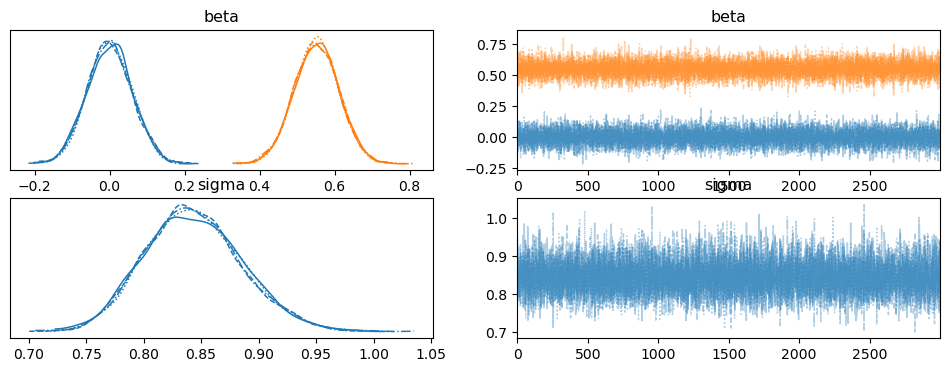

In [8]:
# visualize MCMC samples
az.plot_trace(samples_full)
plt.show()

With the MCMC samples, we visualize the model below

In [9]:
# compute y_hat using the MCMC samples
beta_full_samples = samples_full.posterior['beta'].values.reshape(-1,2)
y_hat_full_scaled_samples = beta_full_samples[:,0] + beta_full_samples[:,1]*x_plot_full_scaled
y_hat_full_scaled_med = np.median(y_hat_full_scaled_samples, axis = 1)
y_hat_full_scaled_u = np.percentile(y_hat_full_scaled_samples, axis = 1, q = 97.5)
y_hat_full_scaled_l = np.percentile(y_hat_full_scaled_samples, axis = 1, q = 2.5)
y_hat_full_med, y_hat_full_u, y_hat_full_l = [Scale_y_full.inverse_transform(y[:,None]) for y in [y_hat_full_scaled_med, y_hat_full_scaled_u, y_hat_full_scaled_l]]

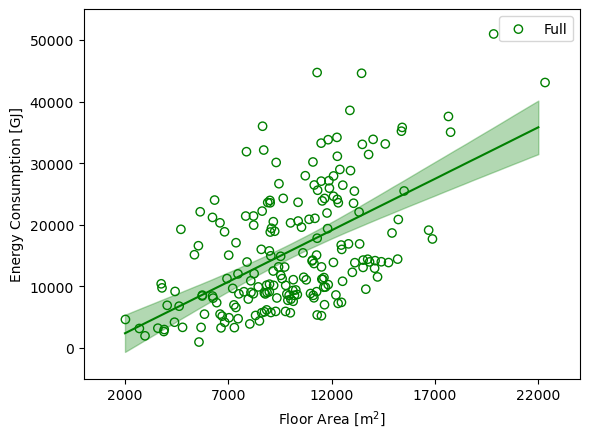

In [10]:
# visualization
plt.subplots()
plt.scatter(Full['Area [m^2]'], Full['Energy [GJ]'], facecolors="None", edgecolors='g',label='Full')
plt.plot(x_plot, y_hat_full_med.flatten(), 'g')
plt.fill_between(x_plot.flatten(), y_hat_full_l.flatten(), y_hat_full_u.flatten(), alpha=0.3, color='g')
plt.xlim(0,24000)
plt.xticks(np.arange(2000,23000,5000))
plt.xlabel('Floor Area [m$^2$]')
plt.ylim(-5000,55000)
plt.ylabel('Energy Consumption [GJ]')
plt.legend()
plt.show()

### Train a Model using the Subset of the Dataset
You can repeat the same process to develop a model using the subset.

In [11]:
# data preprocessing
# Subset
x_subset = Subset['Area [m^2]'].values[:,None]
y_subset = Subset['Energy [GJ]'].values[:,None]
Scale_x_subset = preprocessing.StandardScaler()
x_subset_scaled = Scale_x_subset.fit_transform(x_subset)
Scale_y_subset = preprocessing.StandardScaler()
y_subset_scaled = Scale_y_subset.fit_transform(y_subset)

# points to visualize the models
x_plot_subset_scaled = Scale_x_subset.transform(x_plot)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 49 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

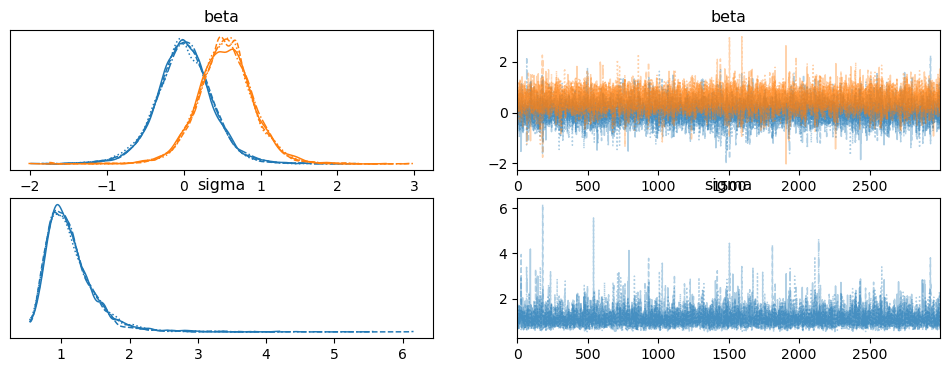

In [12]:
# construct the model for the full dataset
model_subset = pm.Model()
with model_subset:
    # Prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.Exponential("sigma", lam=1/100)

    # Likelihood
    y_hat = beta[1] * x_subset_scaled + beta[0]
    obs = pm.Normal("obs", mu=y_hat, sigma=sigma, observed=y_subset_scaled)

    # draw 1000 posterior samples
    samples_subset = pm.sample(3000)
# visualize MCMC samples
az.plot_trace(samples_subset)

In [13]:
# compute y_hat using the MCMC samples
beta_subset_samples = samples_subset.posterior['beta'].values.reshape(-1,2)
y_hat_subset_scaled_samples = beta_subset_samples[:,0] + beta_subset_samples[:,1]*x_plot_subset_scaled
y_hat_subset_scaled_med = np.median(y_hat_subset_scaled_samples, axis = 1)
y_hat_subset_scaled_u = np.percentile(y_hat_subset_scaled_samples, axis = 1, q = 97.5)
y_hat_subset_scaled_l = np.percentile(y_hat_subset_scaled_samples, axis = 1, q = 2.5)
y_hat_subset_med, y_hat_subset_u, y_hat_subset_l = [Scale_y_subset.inverse_transform(y[:,None]) for y in [y_hat_subset_scaled_med, y_hat_subset_scaled_u, y_hat_subset_scaled_l]]

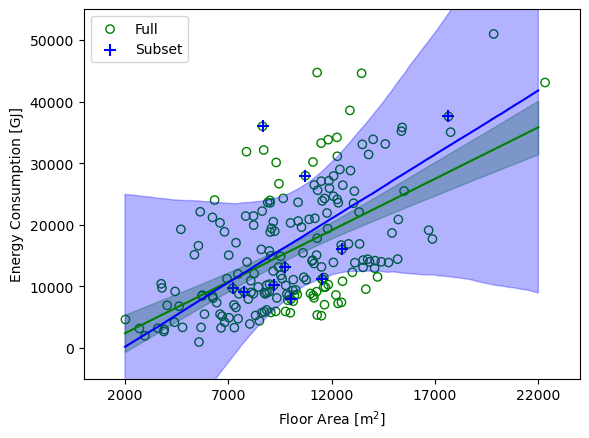

In [14]:
# visualization
plt.subplots()
plt.scatter(Full['Area [m^2]'], Full['Energy [GJ]'], facecolors="None", edgecolors='g',label='Full')
plt.scatter(Subset['Area [m^2]'], Subset['Energy [GJ]'], color='b', marker='+',s=70,label='Subset')
plt.plot(x_plot, y_hat_full_med.flatten(), 'g')
plt.fill_between(x_plot.flatten(), y_hat_full_l.flatten(), y_hat_full_u.flatten(), alpha=0.3, color='g')
plt.plot(x_plot, y_hat_subset_med.flatten(), 'b')
plt.fill_between(x_plot.flatten(), y_hat_subset_l.flatten(), y_hat_subset_u.flatten(), alpha=0.3, color='b')
plt.xlim(0,24000)
plt.xticks(np.arange(2000,23000,5000))
plt.xlabel('Floor Area [m$^2$]')
plt.ylim(-5000,55000)
plt.ylabel('Energy Consumption [GJ]')
plt.legend()
plt.show()

### Train a Model using the Subsubset of the Dataset
You can repeat the same process to develop a model using the subsubset.

In [15]:
# Subsubset
x_subsubset = Subsubset['Area [m^2]'].values[:,None]
y_subsubset = Subsubset['Energy [GJ]'].values[:,None]
Scale_x_subsubset = preprocessing.StandardScaler() 
x_subsubset_scaled = Scale_x_subsubset.fit_transform(x_subsubset) 
Scale_y_subsubset = preprocessing.StandardScaler() 
y_subsubset_scaled = Scale_y_subsubset.fit_transform(y_subsubset)

# points to visualize the models
x_plot_subsubset_scaled = Scale_x_subsubset.transform(x_plot)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 58 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

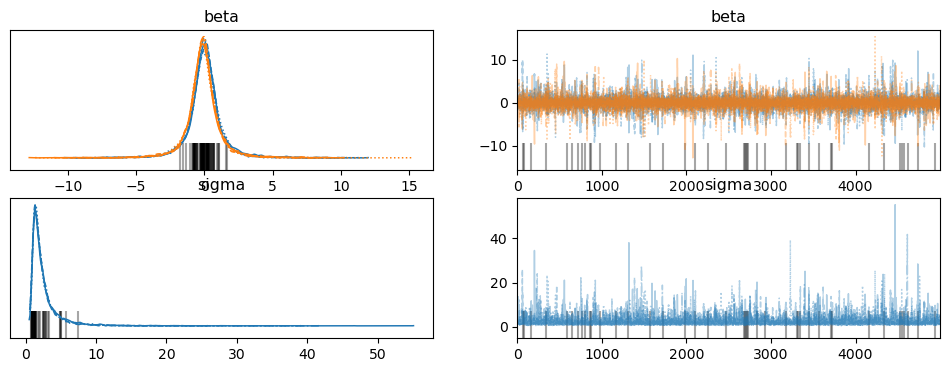

In [16]:
# construct the model for the full dataset
model_subsubset = pm.Model()
with model_subsubset:
    # Prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.Exponential("sigma", lam=1/100)

    # Likelihood
    y_hat = beta[1] * x_subsubset_scaled + beta[0]
    obs = pm.Normal("obs", mu=y_hat, sigma=sigma, observed=y_subsubset_scaled)

    # draw 1000 posterior samples
    samples_subsubset = pm.sample(5000)
# visualize MCMC samples
az.plot_trace(samples_subsubset)

In [17]:
# compute y_hat using the MCMC samples
beta_subsubset_samples = samples_subsubset.posterior['beta'].values.reshape(-1,2)
y_hat_subsubset_scaled_samples = beta_subsubset_samples[:,0] + beta_subsubset_samples[:,1]*x_plot_subsubset_scaled
y_hat_subsubset_scaled_med = np.median(y_hat_subsubset_scaled_samples, axis = 1)
y_hat_subsubset_scaled_u = np.percentile(y_hat_subsubset_scaled_samples, axis = 1, q = 97.5)
y_hat_subsubset_scaled_l = np.percentile(y_hat_subsubset_scaled_samples, axis = 1, q = 2.5)
y_hat_subsubset_med, y_hat_subsubset_u, y_hat_subsubset_l = \
[Scale_y_subsubset.inverse_transform(y[:,None]) for y in [y_hat_subsubset_scaled_med,
                                                          y_hat_subsubset_scaled_u,
                                                          y_hat_subsubset_scaled_l]]

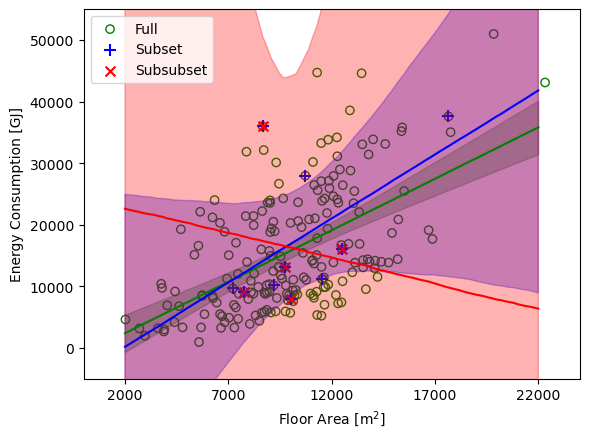

In [18]:
# visualization
plt.subplots()
plt.scatter(Full['Area [m^2]'], Full['Energy [GJ]'], facecolors="None", edgecolors='g',label='Full')
plt.scatter(Subset['Area [m^2]'], Subset['Energy [GJ]'], color='b', marker='+',s=70,label='Subset')
plt.scatter(Subsubset['Area [m^2]'], Subsubset['Energy [GJ]'], color='r', marker='x',s=50,label='Subsubset')
plt.plot(x_plot, y_hat_full_med.flatten(), 'g')
plt.fill_between(x_plot.flatten(), y_hat_full_l.flatten(), y_hat_full_u.flatten(), alpha=0.3, color='g')
plt.plot(x_plot, y_hat_subset_med.flatten(), 'b')
plt.fill_between(x_plot.flatten(), y_hat_subset_l.flatten(), y_hat_subset_u.flatten(), alpha=0.3, color='b')
plt.plot(x_plot, y_hat_subsubset_med.flatten(), 'r')
plt.fill_between(x_plot.flatten(), y_hat_subsubset_l.flatten(), y_hat_subsubset_u.flatten(), alpha=0.3, color='r')
plt.xlim(0,24000)
plt.xticks(np.arange(2000,23000,5000))
plt.xlabel('Floor Area [m$^2$]')
plt.ylim(-5000,55000)
plt.ylabel('Energy Consumption [GJ]')
plt.legend()
plt.show()

### Informative Prior
If you have informative prior probability, that can help our modelling. In this example, let us assume that we know floor area and energy consumption are positively correlated as:
$$
\begin{aligned}
& p(\boldsymbol{\uptheta}) := p(\beta_0) p(\beta_1) p(\sigma) \\\\
& p(\beta_0) := \mathcal{N}(\beta_0|0,100) \\\\
& p(\beta_1) := \text{Exp}(\beta_1|1/100) \\\\
& p(\sigma) := \text{Exp}(\sigma|1/100)
\end{aligned}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 64 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

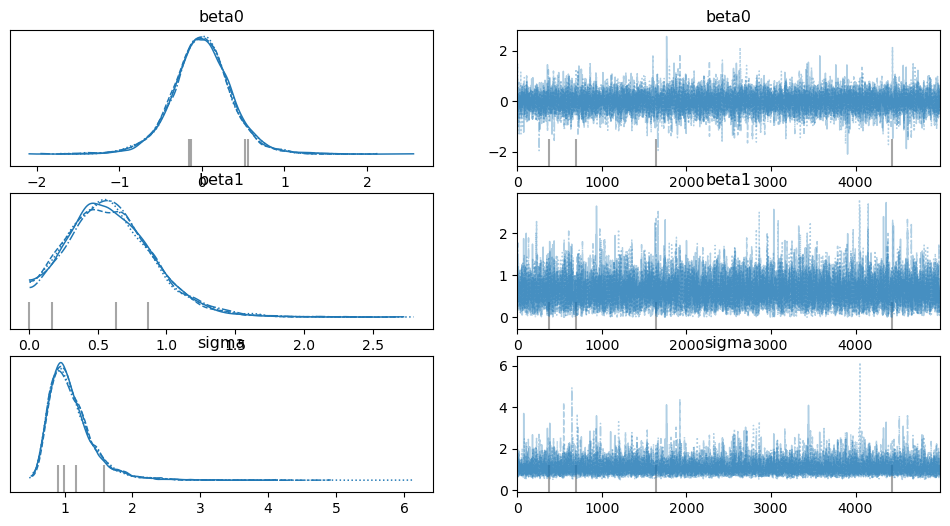

In [19]:
# construct the model for the full dataset
model_subset_info = pm.Model()
with model_subset_info:
    # Prior
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Exponential("beta1", lam=1/100)
    sigma = pm.Exponential("sigma", lam=1/100)

    # Likelihood
    y_hat = beta1 * x_subset_scaled + beta0
    obs = pm.Normal("obs", mu=y_hat, sigma=sigma, observed=y_subset_scaled)

    # draw 1000 posterior samples
    samples_subset_info = pm.sample(5000)
# visualize MCMC samples
az.plot_trace(samples_subset_info)

In [20]:
# compute y_hat using the MCMC samples
y_hat_subset_info_scaled_samples = samples_subset_info.posterior['beta0'].values.flatten() + \
                                   samples_subset_info.posterior['beta1'].values.flatten()*x_plot_subset_scaled
y_hat_subset_info_scaled_med = np.median(y_hat_subset_info_scaled_samples, axis = 1)
y_hat_subset_info_scaled_u = np.percentile(y_hat_subset_info_scaled_samples, axis = 1, q = 97.5)
y_hat_subset_info_scaled_l = np.percentile(y_hat_subset_info_scaled_samples, axis = 1, q = 2.5)
y_hat_subset_info_med, y_hat_subset_info_u, y_hat_subset_info_l = \
[Scale_y_subset.inverse_transform(y[:,None]) for y in [y_hat_subset_info_scaled_med,
                                                       y_hat_subset_info_scaled_u,
                                                       y_hat_subset_info_scaled_l]]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 63 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

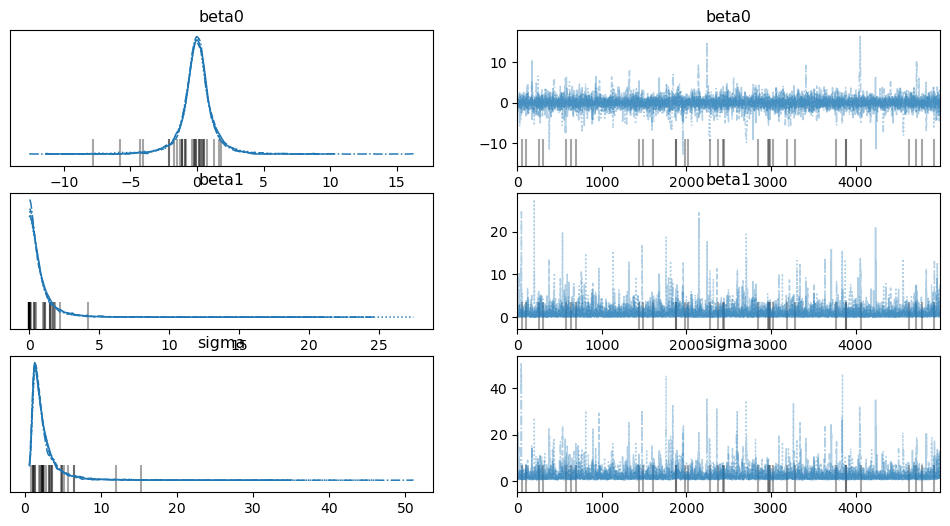

In [21]:
# construct the model for the full dataset
model_subsubset_info = pm.Model()
with model_subsubset_info:
    # Prior
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Exponential("beta1", lam=1/100)
    sigma = pm.Exponential("sigma", lam=1/100)

    # Likelihood
    y_hat = beta1 * x_subsubset_scaled + beta0
    obs = pm.Normal("obs", mu=y_hat, sigma=sigma, observed=y_subsubset_scaled)

    # draw 1000 posterior samples
    samples_subsubset_info = pm.sample(5000)
# visualize MCMC samples
az.plot_trace(samples_subsubset_info)

In [22]:
# compute y_hat using the MCMC samples
y_hat_subsubset_info_scaled_samples = samples_subsubset_info.posterior['beta0'].values.flatten() + \
                                      samples_subsubset_info.posterior['beta1'].values.flatten()*x_plot_subsubset_scaled
y_hat_subsubset_info_scaled_med = np.median(y_hat_subsubset_info_scaled_samples, axis = 1)
y_hat_subsubset_info_scaled_u = np.percentile(y_hat_subsubset_info_scaled_samples, axis = 1, q = 97.5)
y_hat_subsubset_info_scaled_l = np.percentile(y_hat_subsubset_info_scaled_samples, axis = 1, q = 2.5)
y_hat_subsubset_info_med, y_hat_subsubset_info_u, y_hat_subsubset_info_l = \
[Scale_y_subsubset.inverse_transform(y[:,None]) for y in [y_hat_subsubset_info_scaled_med,
                                                          y_hat_subsubset_info_scaled_u,
                                                          y_hat_subsubset_info_scaled_l]]

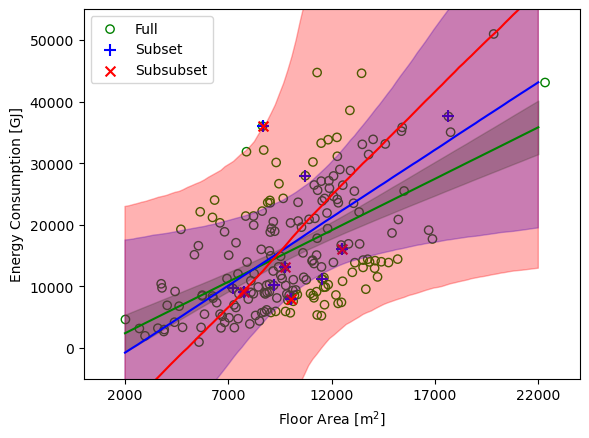

In [23]:
# visualization
plt.subplots()
plt.scatter(Full['Area [m^2]'], Full['Energy [GJ]'], facecolors="None", edgecolors='g',label='Full')
plt.scatter(Subset['Area [m^2]'], Subset['Energy [GJ]'], color='b', marker='+',s=70,label='Subset')
plt.scatter(Subsubset['Area [m^2]'], Subsubset['Energy [GJ]'], color='r', marker='x',s=50,label='Subsubset')
plt.plot(x_plot, y_hat_full_med.flatten(), 'g')
plt.fill_between(x_plot.flatten(), y_hat_full_l.flatten(), y_hat_full_u.flatten(), alpha=0.3, color='g')
plt.plot(x_plot, y_hat_subset_info_med.flatten(), 'b')
plt.fill_between(x_plot.flatten(), y_hat_subset_info_l.flatten(), y_hat_subset_info_u.flatten(), alpha=0.3, color='b')
plt.plot(x_plot, y_hat_subsubset_info_med.flatten(), 'r')
plt.fill_between(x_plot.flatten(), y_hat_subsubset_info_l.flatten(), y_hat_subsubset_info_u.flatten(), alpha=0.3, color='r')
plt.xlim(0,24000)
plt.xticks(np.arange(2000,23000,5000))
plt.xlabel('Floor Area [m$^2$]')
plt.ylim(-5000,55000)
plt.ylabel('Energy Consumption [GJ]')
plt.legend()
plt.show()